In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("/kaggle/input/isic-2019/ISIC_2019_Training_GroundTruth.csv")

In [3]:
df.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Count class distributions
class_counts = df.iloc[:, 1:].sum()
class_counts

MEL      4522.0
NV      12875.0
BCC      3323.0
AK        867.0
BKL      2624.0
DF        239.0
VASC      253.0
SCC       628.0
UNK         0.0
dtype: float64

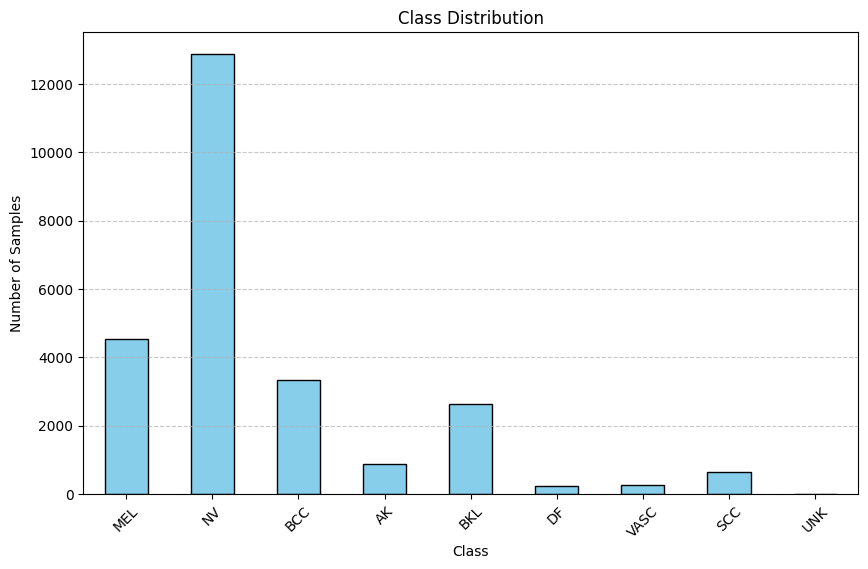

In [5]:
# Plot class distribution
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [7]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import pandas as pd

# Drop 'UNK' column if it exists
if 'UNK' in df.columns:
    df = df.drop('UNK', axis=1)

# Ensure all columns are numeric
label_cols = df.columns[1:]
df[label_cols] = df[label_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.dropna(inplace=True)  # Alternative: df.fillna(0, inplace=True)

# Convert one-hot encoded labels to a single class per row
df['label'] = df[label_cols].idxmax(axis=1)

# Ensure 'image' column exists
if 'image' not in df.columns:
    raise ValueError("The dataset must contain an 'image' column.")

# Count class distribution
class_counts = df['label'].value_counts()
majority_class = class_counts.idxmax()
majority_class_count = class_counts.max()

# Step-1: Undersample the majority class
undersample_ratio = 0.5  # Adjust as needed
undersample_strategy = {majority_class: int(undersample_ratio * majority_class_count)}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_under, Y_under = rus.fit_resample(df[['image']], df['label'])

# Create a new DataFrame after undersampling
df_under = pd.DataFrame(X_under, columns=['image'])
df_under['label'] = Y_under

# Step-2: Oversample minority classes
class_counts_under = df_under['label'].value_counts()
new_majority_class_count = class_counts_under.max()

# Define oversampling strategy
sampling_strategy = {cls: new_majority_class_count for cls in class_counts_under.index}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_resampled, Y_resampled = ros.fit_resample(df_under[['image']], df_under['label'])

# Convert back to one-hot encoding
df_resampled = pd.DataFrame(X_resampled, columns=['image'])
one_hot_labels = pd.get_dummies(Y_resampled)

# Ensure all original labels exist in one-hot encoding
for col in label_cols:
    if col not in one_hot_labels.columns:
        one_hot_labels[col] = 0

# Merge back into final dataset
df_resampled = pd.concat([df_resampled, one_hot_labels], axis=1)

# Save the balanced dataset
df_resampled.to_csv('Balanced_Dataset.csv', index=False)
print('Balanced dataset saved successfully with full class balance.')

Balanced dataset saved successfully with full class balance.


New Class Distribution:
AK      6437
BCC     6437
BKL     6437
DF      6437
MEL     6437
NV      6437
SCC     6437
VASC    6437
dtype: int64


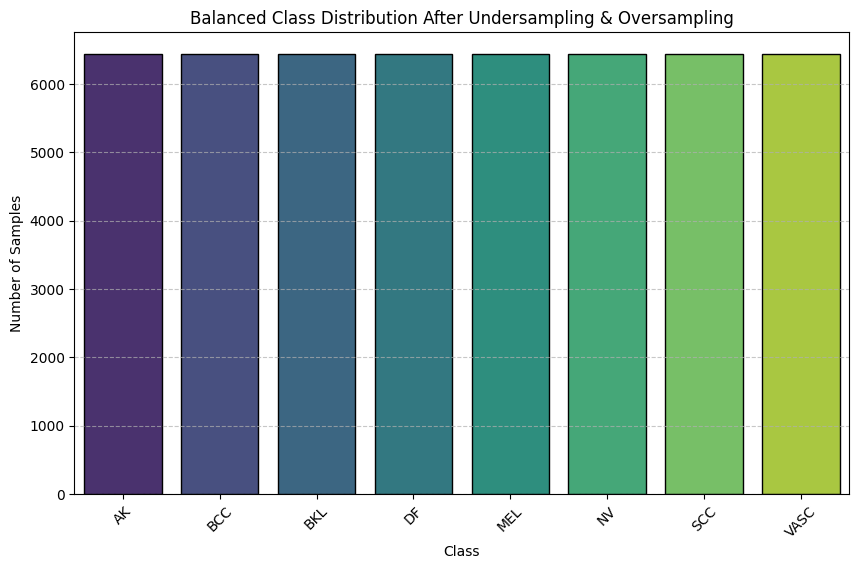

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the new class distribution
new_class_counts = df_resampled.iloc[:, 1:].sum()

# Print new class distribution
print("New Class Distribution:")
print(new_class_counts)

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=new_class_counts.index, y=new_class_counts.values, palette="viridis", edgecolor="black")
plt.title("Balanced Class Distribution After Undersampling & Oversampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [9]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB7
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight

In [10]:
base_dir = "/kaggle/input/isic-2019/ISIC_2019_Training_Input/ISIC_2019_Training_Input"
groundtruth_path = "/kaggle/working/Balanced_Dataset.csv"
labels = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']
img_size = 600  
batch_size = 8
epochs = 50

In [11]:
groundtruth = pd.read_csv(groundtruth_path)
groundtruth['label'] = groundtruth[labels].idxmax(axis=1)
groundtruth.head()

,image,AK,BCC,BKL,DF,MEL,NV,SCC,VASC,label
0,ISIC_0024468,True,False,False,False,False,False,False,False,AK
1,ISIC_0024470,True,False,False,False,False,False,False,False,AK
2,ISIC_0024511,True,False,False,False,False,False,False,False,AK
3,ISIC_0024646,True,False,False,False,False,False,False,False,AK
4,ISIC_0024654,True,False,False,False,False,False,False,False,AK


In [12]:
file_paths = [os.path.join(base_dir, row['image'] + '.jpg') for _, row in groundtruth.iterrows()]
labels_indices = [labels.index(row['label']) for _, row in groundtruth.iterrows()]

In [13]:
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    file_paths, labels_indices, test_size=0.4, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

In [14]:
print(f"Total Images: {len(file_paths)} images")
print(f"Training Set: {len(train_paths)} images ({len(train_paths) / len(file_paths) * 100:.2f}%)")
print(f"Validation Set: {len(val_paths)} images ({len(val_paths) / len(file_paths) * 100:.2f}%)")
print(f"Test Set: {len(test_paths)} images ({len(test_paths) / len(file_paths) * 100:.2f}%)")


Total Images: 51496 images
Training Set: 30897 images (60.00%)
Validation Set: 10299 images (20.00%)
Test Set: 10300 images (20.00%)


In [15]:
def preprocess_image(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.efficientnet.preprocess_input(img)  # Ensure correct preprocessing
    return img, label

In [16]:
data_gen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,  # Slightly reduced to avoid excessive shifts
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=(0.8, 1.2),  # Fixed format
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),  # Fixed format
    fill_mode='nearest'
)

In [17]:
def preprocess_and_augment(file_path, label):
    img, label = preprocess_image(file_path, label)  # Preprocess first
    
    img = tf.image.random_flip_left_right(img)  # Horizontal flip (safe)

    img = tf.image.random_brightness(img, max_delta=0.2)  # Brightness change
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Contrast change
    
    img = tf.cast(img, tf.float32) / 255.0  # Normalize to [0,1]
    img = tf.clip_by_value(img, 0.0, 1.0)  # Keep values in valid range

    return img, label


In [18]:
# Convert lists to tf.constant to avoid potential TypeError
train_paths = tf.constant(train_paths)
train_labels = tf.constant(train_labels, dtype=tf.int32)

val_paths = tf.constant(val_paths)
val_labels = tf.constant(val_labels, dtype=tf.int32)

test_paths = tf.constant(test_paths)
test_labels = tf.constant(test_labels, dtype=tf.int32)

# Create TensorFlow datasets with optimized data loading
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
    .shuffle(1024)  # Shuffle before mapping
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


In [19]:
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [20]:
# Unfreeze the base model
base_model.trainable = True  


fine_tune_at = 300  

# Freeze layers before 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [21]:
inputs = tf.keras.Input(shape=(img_size, img_size, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.005))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(labels), activation="softmax")(x)
model = models.Model(inputs, outputs)

In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 600, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb7 (Functional)          │ (None, 19, 19, 2560)        │      64,097,687 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2560)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,311,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           4,104 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,413,023 (249.53 MB)

 Trainable params: 63,376,248 (241.76 MB)

 Non-trainable params: 2,036,775 (7.77 MB)

In [23]:
# Compile the model with correct loss function
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)

In [24]:
# Callbacks
checkpoint_path = "model.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

In [25]:
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/5
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.6291 - loss: 2.5999
Epoch 1: accuracy improved from -inf to 0.74023, saving model to model.keras
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 2967s 733ms/step - accuracy: 0.6291 - loss: 2.5996 - val_accuracy: 0.8778 - val_loss: 0.4315
Epoch 2/5
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.8740 - loss: 0.4521
Epoch 2: accuracy improved from 0.74023 to 0.88798, saving model to model.keras
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 2765s 716ms/step - accuracy: 0.8740 - loss: 0.4521 - val_accuracy: 0.9223 - val_loss: 0.2931
Epoch 3/5
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 632ms/step - accuracy: 0.9216 - loss: 0.2947
Epoch 3: accuracy improved from 0.88798 to 0.92909, saving model to model.keras
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 2767s 716ms/step - accuracy: 0.9216 - loss: 0.2947 - val_accuracy: 0.9327 - val_loss: 0.2659
Epoch 4/5
3863/3863 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.9488 - loss: 0.2103
Epoch 4: accuracy improved from 0.9

In [26]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Loss on the test set: {test_loss:.4f}")
print(f"Accuracy on the test set: {test_accuracy:.4f}")

Loss on the test set: 0.2516
Accuracy on the test set: 0.9417


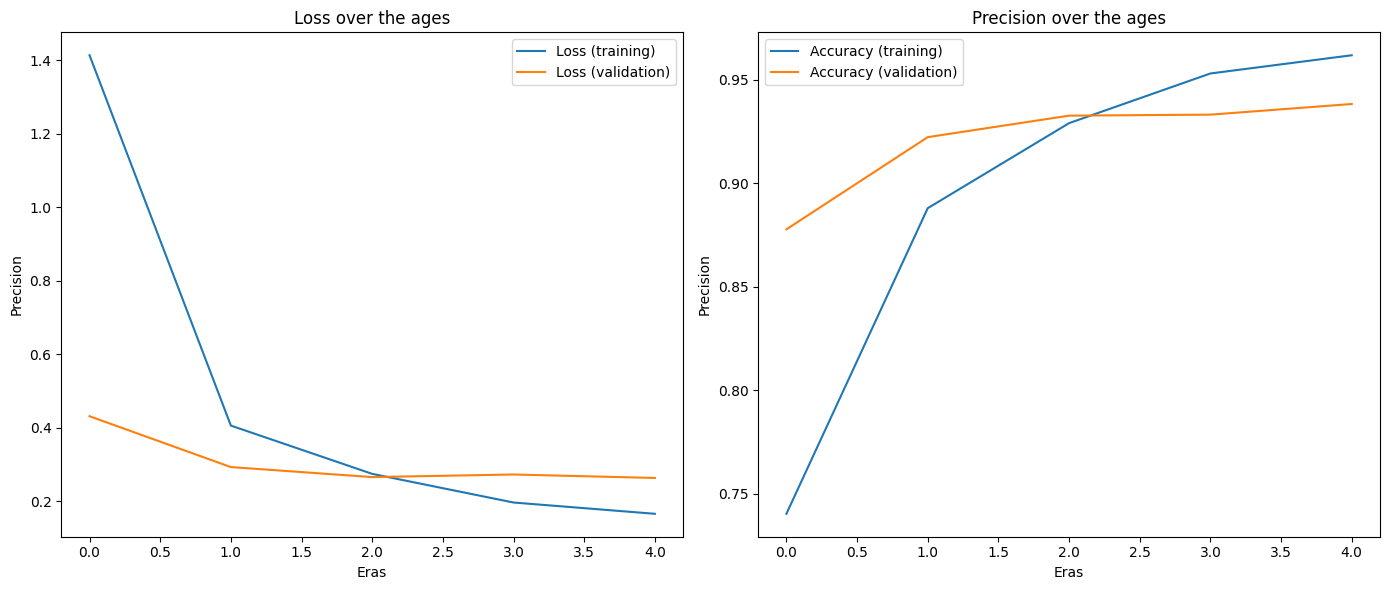

In [27]:
# Training curve
plt.figure(figsize=(14, 6))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss (training)')
plt.plot(history.history['val_loss'], label='Loss (validation)')
plt.title('Loss over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

# Precision curve
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy (training)')
plt.plot(history.history['val_accuracy'], label='Accuracy (validation)')
plt.title('Precision over the ages')
plt.xlabel('Eras')
plt.ylabel('Precision')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_dataset], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

In [29]:
# Classification report
true_classes = np.unique(y_true)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=[labels[i] for i in true_classes]))


Classification Report:

              precision    recall  f1-score   support

         MEL       0.93      0.77      0.84      1257
          NV       0.81      0.91      0.86      1237
         BCC       0.95      0.92      0.94      1295
          AK       0.97      1.00      0.98      1341
         BKL       0.93      0.93      0.93      1334
          DF       1.00      1.00      1.00      1286
        VASC       0.99      1.00      1.00      1306
         SCC       0.96      1.00      0.98      1244

    accuracy                           0.94     10300
   macro avg       0.94      0.94      0.94     10300
weighted avg       0.94      0.94      0.94     10300



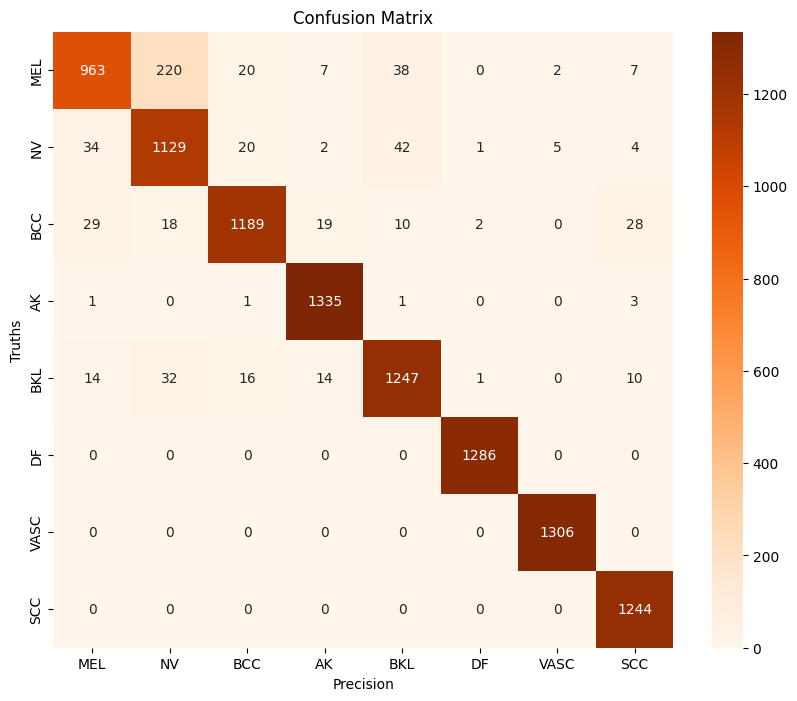

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=true_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=[labels[i] for i in true_classes],
            yticklabels=[labels[i] for i in true_classes], cmap="Oranges")
plt.title("Confusion Matrix")
plt.xlabel("Precision")
plt.ylabel("Truths")
plt.show()

In [31]:
# Normalized confusion matrix
y_true = np.concatenate([y for _, y in test_dataset], axis=0)
y_pred = np.concatenate([np.argmax(model.predict(x), axis=1) for x, _ in test_dataset], axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

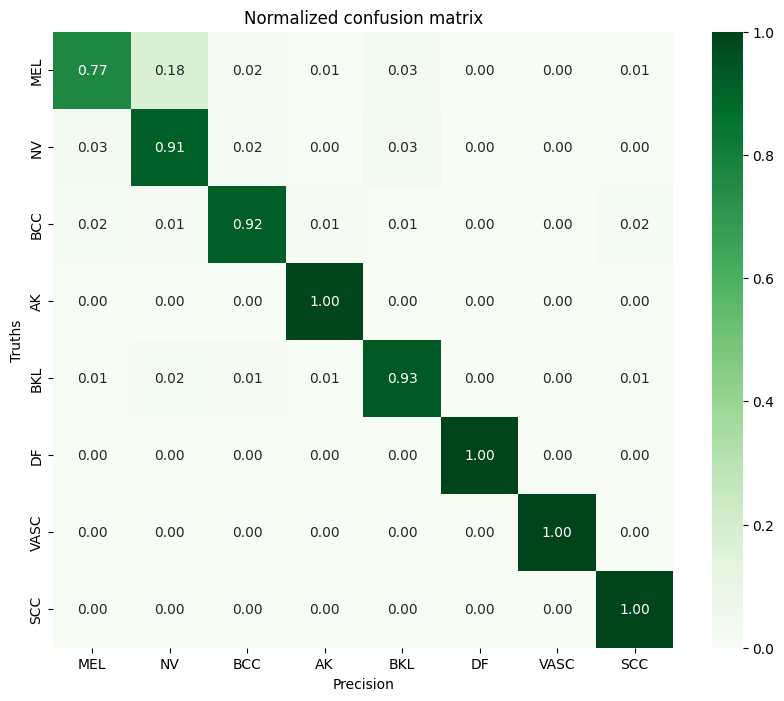

In [32]:
conf_matrix = confusion_matrix(y_true, y_pred, normalize="true")
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt=".2f",
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized confusion matrix")
plt.xlabel("Precision")
plt.ylabel("Truths")
plt.show()

In [33]:
from sklearn.preprocessing import label_binarize

# Binary class labels
y_true_bin = label_binarize(y_true, classes=range(len(labels)))

# Calculating model probability scores
y_pred_probs = model.predict(test_dataset, batch_size=batch_size)

1288/1288 ━━━━━━━━━━━━━━━━━━━━ 333s 248ms/step


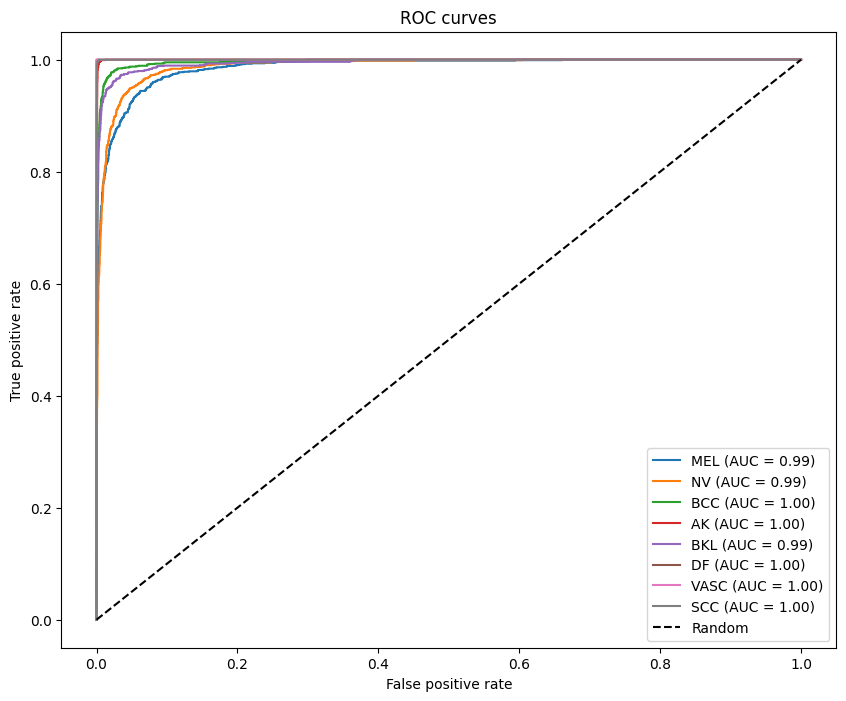

In [34]:
# Calculation of the ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC curves")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend()
plt.show()

In [35]:
import random

In [36]:
class_images = {i: [] for i in range(len(labels))}

In [38]:
# Group test images by their class
for path, label in zip(test_paths, test_labels):
    class_images[int(label)].append(path) 

In [39]:
# Select 4 random images per class
num_samples_per_class = 4
selected_images = []
true_labels = []

for class_label, images in class_images.items():
    selected = random.sample(images, num_samples_per_class) if len(images) >= num_samples_per_class else images
    selected_images.extend(selected)
    true_labels.extend([class_label] * len(selected))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━

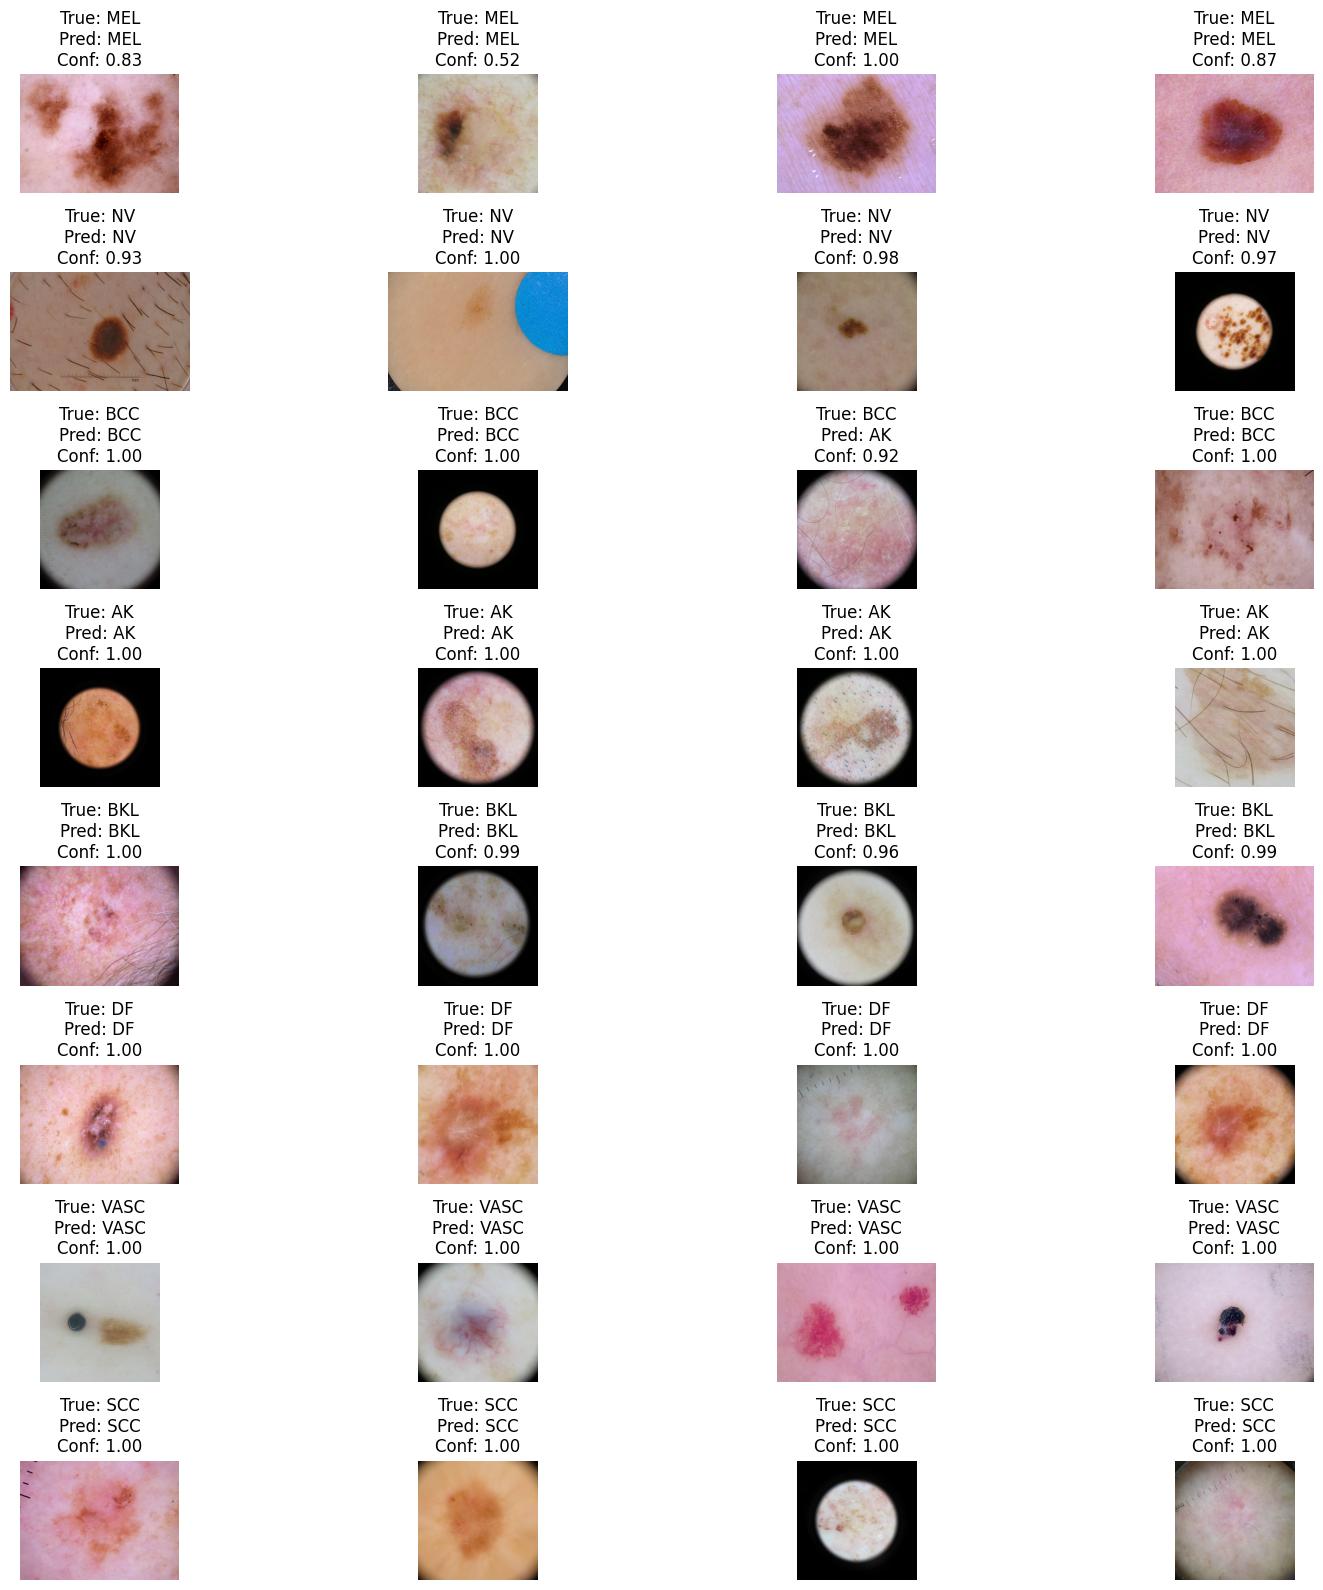

In [40]:
# Plotting setup
fig, axes = plt.subplots(8, 4, figsize=(16, 16))
axes = axes.flatten()

for i, (img_path, true_label) in enumerate(zip(selected_images, true_labels)):
    # Load and preprocess the image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    
    # Expand dimensions for batch processing
    img_array = tf.expand_dims(img, axis=0)
    
    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    # Display the image and predictions
    axes[i].imshow(tf.image.decode_jpeg(tf.io.read_file(img_path)).numpy())
    axes[i].axis("off")
    axes[i].set_title(f"True: {labels[true_label]}\nPred: {labels[predicted_class]}\nConf: {confidence:.2f}")

plt.tight_layout()
plt.show()

# Web Application using Streamlit

In [41]:
pip install streamlit tensorflow pillow reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 96.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [42]:
import os
print(os.listdir("/kaggle/working"))

['model.keras', 'Balanced_Dataset.csv', '.virtual_documents']


In [43]:
import os
import numpy as np
import tensorflow as tf
import streamlit as st
from PIL import Image
from reportlab.pdfgen import canvas

# Load the trained model
MODEL_PATH = "model.keras"  # Update this with the correct model path
model = tf.keras.models.load_model(MODEL_PATH)

# Define class labels
LABELS = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']

# Function to preprocess the uploaded image
def preprocess_image(img):
    img = img.resize((600, 600))  # Resize to match model input
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return img_array

# Function to generate a PDF report
def generate_pdf(predictions):
    pdf_path = "classification_report.pdf"
    c = canvas.Canvas(pdf_path)
    c.drawString(100, 800, "Skin Lesion Classification Report")

    y_position = 750
    for label, prob in predictions.items():
        c.drawString(100, y_position, f"{label}: {prob:.4f}")
        y_position -= 20

    c.save()
    return pdf_path

# Streamlit UI
st.title("🔬 Skin Lesion Classification Web App")
st.write("Upload an image of a skin lesion to get classification probabilities.")

# File uploader
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

if uploaded_file is not None:
    # Display uploaded image
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_column_width=True)

    # Preprocess and predict
    img_array = preprocess_image(image)
    predictions = model.predict(img_array)[0]
    pred_dict = {LABELS[i]: float(predictions[i]) for i in range(len(LABELS))}

    # Show predictions
    st.subheader("📊 Prediction Probabilities:")
    st.write(pred_dict)

    # Generate and provide PDF download
    pdf_path = generate_pdf(pred_dict)
    with open(pdf_path, "rb") as pdf_file:
        st.download_button("📄 Download Report as PDF", pdf_file, file_name="classification_report.pdf")



2025-03-05 12:36:20.359 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.459 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-05 12:36:20.460 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.462 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.464 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-05 12:36:20.465 Thread 'MainThread': mi